---
title: "Some Grouping Problems with SQL"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-11-20"
description: "Aggregating hierarchical data with `GROUP BY` and `PARTITION BY` statements in SQL."
draft: false
categories:  ['SQL', 'Data Management']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
    code-line-numbers: true
    highlight-style: github
---

In [225]:
#| code-line-numbers: false
import duckdb
import pandas as pd
import random
from IPython.display import display, Markdown

Lately I've been struggling through some SQL query development, and I thought it would be useful to write out some of what I've been learning in a blog post. Specifically, I've been thinking about how to do various grouping tasks when data have a hierarchical structure. I'll cover the following SQL concepts:  

- The `GROUP BY` clause
- The `PARTITION BY` clause
- An aggregation task complicated by a dataset's hierarchy

This post is also an opportunity to overview how I display **and** run SQL code with syntax highlighting in Quarto -- a nontrivial task as it turns out!

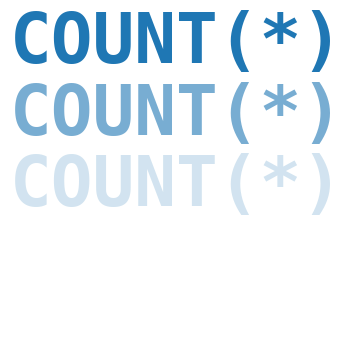

In [272]:
#| output: false
#| echo: false
import matplotlib.pyplot as plt
# Create a blank plot
fig, ax = plt.subplots(figsize=(3, 3.5))
size = 50
space = .25
start = 1
ax.text(
    0.5, start,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    ha='center',
    weight="bold",
    va='center',
    fontfamily='monospace',
    alpha=1
)
ax.text(
    0.5, start-space,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    ha='center',
    weight="bold",
    va='center',
    fontfamily='monospace',
    alpha=.6
)
ax.text(
    0.5, start - space*2,
    "COUNT(*)",
    color= "tab:blue",
    fontsize=size,
    weight="bold",
    ha='center',
    va='center',
    fontfamily='monospace',
    alpha=.2
)

ax.set_axis_off()
fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

To start, I'll synthesize an example dataset. I'll go over the specifics later, but for now just note that this is a standard `pandas` dataframe stored in local memory as `transactions`. It contains fake credit card transactions at payment terminals, and flags denoting whether the cardholder identified the transaction as suspicious or not.

In [269]:
#| output: false
#| code-line-numbers: false
random.seed(42)
n = 100
data = {
    "card_number": [f"{random.randint(90000, 90099)}" for _ in range(n)],
    "terminal": [random.choice(["A", "B"]) for _ in range(n)],
    "transaction_date": [f"2024-11-{random.randint(15, 17)}" for _ in range(n)],
    "suspicious_flag": [random.choice([0, 1]) for _ in range(n)],
}
transactions = pd.DataFrame(data)

## Connecting to a `pandas` data frame in `duckdb`
The data I simulated are quite small, so using SQL isn't going to be very practically useful. However, I find that it's still quite useful to play with small SQL databases like this to build general comfort with the language and to get a better intuition of how the operation will play out when you are working at scale. 

I'm going to use the [`duckdb` database system](https://duckdb.org/) to directly query the `pandas` data frame I have in local memory (Note that `duckdb` can also directly query [parquet files, csv files, and more](https://duckdb.org/docs/api/python/overview.html#data-input)).

In [216]:
#| code-line-numbers: false
duckdb.sql("SELECT * FROM transactions LIMIT 5;")

┌─────────────┬──────────┬──────────────────┬─────────────────┐
│ card_number │ terminal │ transaction_date │ suspicious_flag │
│   varchar   │ varchar  │     varchar      │      int64      │
├─────────────┼──────────┼──────────────────┼─────────────────┤
│ 90081       │ B        │ 2024-11-15       │               0 │
│ 90014       │ B        │ 2024-11-17       │               0 │
│ 90003       │ B        │ 2024-11-15       │               0 │
│ 90094       │ A        │ 2024-11-16       │               1 │
│ 90035       │ B        │ 2024-11-17       │               0 │
└─────────────┴──────────┴──────────────────┴─────────────────┘

### Executing and displaying SQL in Quarto

The fact that `duckdb` can directly query data in memory is great, but two issues arise -- the SQL code doesn't have any syntax highlighting, and it would be preferable if the output were a data frame rather than plain text. I'll create a wrapper function, `run_query` that solves these issues:


In [217]:
#| code-line-numbers: false
def run_query(sql_str: str) -> pd.DataFrame:
  display(Markdown("```sql\n" + sql_str.strip("\n") + "\n```"))
  return duckdb.sql(sql_str).df()


Note the following code elements:  

1. `display(Markdown(...))`  will display `sql_str`, the string code for the query, but with a wrapper around it as follows:  

```{{sql}}  
sql_str 
```  

The wrapper alerts Quarto that it should provide SQL syntax-highlighting for the code output.  

2. `duckdb.sql(sql_str).df()` returns the results of the SQL query as a `pd.DataFrame` object rather than the text-table rendered above.  


From here on out, I will use that function, within cells with the setting `echo: false` to carry out my SQL queries. Thus, you won't see the python function, just a code chunk of the SQL query code and the query result. Here's an example query, looking at the first five rows of `transactions`:

In [220]:
#| echo: false
run_query(
"""
SELECT * FROM transactions
LIMIT 5;
""")

```sql
SELECT * FROM transactions
LIMIT 5;
```

,card_number,terminal,transaction_date,suspicious_flag
0,90081,B,2024-11-15,0
1,90014,B,2024-11-17,0
2,90003,B,2024-11-15,0
3,90094,A,2024-11-16,1
4,90035,B,2024-11-17,0


Note the hierarchy of these transaction data. We start with Payment terminals:  

- **Terminal**
  - A terminal can have multiple **Cards** that interact with it.
    - **Card**
      - A card can make multiple **Transactions** at a terminal on different or the same days.
        - **Transaction**
          - Associated with:
            - **Transaction date**
            - **Suspicious transaction flag**


I'll proceed to look at a few key SQL methods using these data.

## Aggregating with `GROUP BY`
Let's say we were only interested in counting total transactions and total suspicious transactions for each terminal on each day. This is a group aggregation task, where we want to calculate summary statistics (two counts) for subsets of the data grouped by one or more columns. In SQL this is done using the `GROUP BY` clause and an aggregation function (`COUNT` and `SUM` in this case). Equivalent `pandas` code is available via the navbar. In this case, I like the SQL and `pandas` syntax about equally.

::: {.panel-tabset}

## SQL

In [226]:
#| echo: false
run_query(f"""
SELECT
  terminal,
  transaction_date,
  COUNT(*) as n_transactions,
  SUM(suspicious_flag) as n_suspicious_transactions
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
ORDER BY
  terminal,
  transaction_date;
""")

```sql
SELECT
  terminal,
  transaction_date,
  COUNT(*) as n_transactions,
  SUM(suspicious_flag) as n_suspicious_transactions
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
ORDER BY
  terminal,
  transaction_date;
```

,terminal,transaction_date,n_transactions,n_suspicious_transactions
0,A,2024-11-15,21,11.0
1,A,2024-11-16,18,10.0
2,A,2024-11-17,16,5.0
3,B,2024-11-15,19,7.0
4,B,2024-11-16,13,6.0
5,B,2024-11-17,13,5.0


## `pandas`

In [208]:
(
    transactions
    .groupby(['terminal', 'transaction_date'], as_index=False)
    .agg(
        n_transactions=('transaction_date', 'size'),
        n_suspicious_transactions=('suspicious_flag', 'sum')
    )
    .sort_values(by=['terminal', 'transaction_date'])
)


,terminal,transaction_date,n_transactions,n_suspicious_transactions
0,A,2024-11-15,21,11
1,A,2024-11-16,18,10
2,A,2024-11-17,16,5
3,B,2024-11-15,19,7
4,B,2024-11-16,13,6
5,B,2024-11-17,13,5


:::

Note that the `GROUP BY` operation reduces our data granularity down to the unique terminal-date pairs. This is typical aggregation behavior. Also note in lines 4 and 5 of the SQL code, that for transactions, I use `COUNT(*)`. This simply counts all rows within the group. In the case of the suspicious transaction flags, I use `SUM(suspicious_flag)` within groups since the column is a 1/0 integer flag.

## Aggregating with `PARTITION BY`

The Partition is an odd cousin of the Group that I became aware of only recently. In essence, it accomplishes the same thing as `GROUP BY`, but it doesn't compress the input data, instead it returns a dataframe with the aggregate result replicated at every row where the group exists. This is clearer via example.  

Note in the following output that the number of suspicious transactions at Terminal A on 11/15/2024 is the same as it was in the grouped output above, but it repeats for every row from Terminal A on 11/15/2024. The `pandas` implementation for this task, available via the navbar, relies on the combination of `groupby()` and `transform()`, which I find unintuitive.

::: {.panel-tabset}

## SQL

In [227]:
#| echo: false
run_query(
"""
SELECT
    *,
    SUM(suspicious_flag)
        OVER (PARTITION BY terminal, transaction_date)
    as total_sus_trans_at_term
FROM transactions
ORDER BY
  terminal,
  transaction_date;
""")

```sql
SELECT
    *,
    SUM(suspicious_flag)
        OVER (PARTITION BY terminal, transaction_date)
    as total_sus_trans_at_term
FROM transactions
ORDER BY
  terminal,
  transaction_date;
```

,card_number,terminal,transaction_date,suspicious_flag,total_sus_trans_at_term
0,90028,A,2024-11-15,0,11.0
1,90011,A,2024-11-15,1,11.0
2,90091,A,2024-11-15,1,11.0
3,90053,A,2024-11-15,0,11.0
4,90028,A,2024-11-15,1,11.0
...,...,...,...,...,...
95,90033,B,2024-11-17,0,5.0
96,90037,B,2024-11-17,1,5.0
97,90029,B,2024-11-17,0,5.0
98,90020,B,2024-11-17,0,5.0


## `pandas`

In [212]:
(
    transactions
    .assign(total_sus_trans_at_term=
            transactions
            .groupby(['terminal', 'transaction_date'])['suspicious_flag']
            .transform('sum')
    )
    .sort_values(by=['terminal', 'transaction_date'])
)


,card_number,terminal,transaction_date,suspicious_flag,total_sus_trans_at_term
6,90028,A,2024-11-15,0,11
18,90011,A,2024-11-15,1,11
26,90091,A,2024-11-15,1,11
30,90053,A,2024-11-15,0,11
31,90028,A,2024-11-15,1,11
...,...,...,...,...,...
53,90033,B,2024-11-17,0,5
74,90037,B,2024-11-17,1,5
76,90029,B,2024-11-17,0,5
83,90020,B,2024-11-17,0,5


:::

Thus, `PARTITION BY` preserves the long format of the data, while still allowing for the creation of aggregate columns.

## Complex aggregation tasks

Now let's use `GROUP BY` and `PARTITION BY` together in a complex query.

Suppose we want to know the number of suspicious transactions at each terminal each day, but we also want to have access to some information about whether that number of suspicious transactions is typical, or is an outlier, for that terminal. We can use a z-score to measure the position of a suspicious card count within some distribution, but computing both the count of suspicious cards at the terminal-date level, then computing z-scores per store is complicated.  

It is of course relatively simple to break this into steps in `pandas`. However, in SQL, breaking tasks into steps involves Common Table Expressions ([CTEs](https://duckdb.org/docs/sql/query_syntax/with.html)), and things can start to get complicated, particularly when it's hard to determine what each CTE outputs. Below, I show a full query that uses both `GROUP BY` and `PARTITION BY` to complete this task, but I also include a navigation bar that allows one to see what each of the three select statements outputs, thus expressing the query as a series of steps.

::: {.panel-tabset}


## Full Query

In [ ]:
#| echo: false
run_query(f"""
WITH grouped_table as (
  SELECT
    terminal,
    transaction_date,
    COUNT(*) as n_transactions,
    SUM(suspicious_flag) as n_suspicious_transactions
  FROM
    transactions
  GROUP BY
    terminal,
    transaction_date
),
          
partitions_table as (
  SELECT
    *,
    AVG(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_average,
    STDDEV_POP(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_std,
  FROM grouped_table
)

SELECT
  terminal,
  transaction_date,
  n_transactions,
  n_suspicious_transactions,
  (n_suspicious_transactions - terminal_average) / terminal_std as terminal_z_score
FROM partitions_table;
"""
    )

```sql
WITH grouped_table as (
  SELECT
    terminal,
    transaction_date,
    COUNT(*) as n_transactions,
    SUM(suspicious_flag) as n_suspicious_transactions
  FROM
    transactions
  GROUP BY
    terminal,
    transaction_date
),
          
partitions_table as (
  SELECT
    *,
    AVG(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_average,
    STDDEV_POP(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_std,
  FROM grouped_table
)

SELECT
  terminal,
  transaction_date,
  n_transactions,
  n_suspicious_transactions,
  (n_suspicious_transactions - terminal_average) / terminal_std as terminal_z_score
FROM partitions_table;
```

,terminal,transaction_date,n_transactions,n_suspicious_transactions,terminal_z_score
0,A,2024-11-17,16,5.0,-1.397001
1,A,2024-11-16,18,10.0,0.508001
2,A,2024-11-15,21,11.0,0.889001
3,B,2024-11-17,13,5.0,-1.224745
4,B,2024-11-15,19,7.0,1.224745
5,B,2024-11-16,13,6.0,0.000000


## Step 1

We start with the same basic grouped table, where each row is a unique terminal-date combination with its total transactions and total suspicious transactions.

In [254]:
#| echo: false
grouped_table = run_query(f"""
WITH grouped_table as (
  SELECT
    terminal,
    transaction_date,
    COUNT(*) as n_transactions,
    SUM(suspicious_flag) as n_suspicious_transactions
  FROM
    transactions
  GROUP BY
    terminal,
    transaction_date
)
SELECT * FROM grouped_table
"""
)
grouped_table

```sql
WITH grouped_table as (
  SELECT
    terminal,
    transaction_date,
    COUNT(*) as n_transactions,
    SUM(suspicious_flag) as n_suspicious_transactions
  FROM
    transactions
  GROUP BY
    terminal,
    transaction_date
)
SELECT * FROM grouped_table
```

,terminal,transaction_date,n_transactions,n_suspicious_transactions
0,B,2024-11-17,13,5.0
1,A,2024-11-17,16,5.0
2,A,2024-11-15,21,11.0
3,B,2024-11-16,13,6.0
4,B,2024-11-15,19,7.0
5,A,2024-11-16,18,10.0


## Step 2

We proceed to use `PARTITION BY` statements on that grouped table, finding the average and standard deviation across dates for each terminal.

In [253]:
#| echo: false
partitions_table = run_query(f"""
WITH partitions_table as (
  SELECT
    *,
    AVG(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_average,
    STDDEV_POP(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_std,
  FROM grouped_table
)
SELECT * FROM partitions_table;
"""
    )
partitions_table

```sql
WITH partitions_table as (
  SELECT
    *,
    AVG(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_average,
    STDDEV_POP(n_suspicious_transactions) OVER (PARTITION BY terminal) as terminal_std,
  FROM grouped_table
)
SELECT * FROM partitions_table;
```

,terminal,transaction_date,n_transactions,n_suspicious_transactions,terminal_average,terminal_std
0,A,2024-11-17,16,5.0,8.666667,2.624669
1,A,2024-11-15,21,11.0,8.666667,2.624669
2,A,2024-11-16,18,10.0,8.666667,2.624669
3,B,2024-11-16,13,6.0,6.000000,0.816497
4,B,2024-11-17,13,5.0,6.000000,0.816497
5,B,2024-11-15,19,7.0,6.000000,0.816497


## Step 3

Finally, we can write a straightforward select statement that gets our desired final columns out of `partitions_table`.

In [255]:
#| echo: false
run_query(f"""
SELECT
  terminal,
  transaction_date,
  n_transactions,
  n_suspicious_transactions,
  (n_suspicious_transactions - terminal_average) / terminal_std as terminal_z_score
FROM partitions_table;
"""
    )

```sql
SELECT
  terminal,
  transaction_date,
  n_transactions,
  n_suspicious_transactions,
  (n_suspicious_transactions - terminal_average) / terminal_std as terminal_z_score
FROM partitions_table;
```

,terminal,transaction_date,n_transactions,n_suspicious_transactions,terminal_z_score
0,A,2024-11-17,16,5.0,-1.397001
1,A,2024-11-15,21,11.0,0.889001
2,A,2024-11-16,18,10.0,0.508001
3,B,2024-11-16,13,6.0,0.000000
4,B,2024-11-17,13,5.0,-1.224745
5,B,2024-11-15,19,7.0,1.224745


:::

## Grouping on Cards
What is we were instead focused on cards?

In [188]:
#| echo: false
run_query(
f"""
SELECT
  terminal,
  transaction_date,
  COUNT(DISTINCT card_number) AS num_cards
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
"""
    )

```sql
SELECT
  terminal,
  transaction_date,
  COUNT(DISTINCT card_number) AS num_cards
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
```

,terminal,transaction_date,num_cards
0,B,2024-11-17,13
1,A,2024-11-17,15
2,B,2024-11-16,12
3,A,2024-11-15,17
4,A,2024-11-16,18
5,B,2024-11-15,15


https://stackoverflow.com/questions/54425477/group-by-case-when-in-other-column-with-pandas

In [256]:
(
    transactions
    .groupby(['terminal', 'transaction_date', 'suspicious_flag'])
    ['card_number'].nunique()
    .unstack()
    .assign(n_cards = lambda x: x.sum(axis=1))
    )

suspicious_flag             0   1  n_cards
terminal transaction_date                 
A        2024-11-15         9  10       19
         2024-11-16         8  10       18
         2024-11-17        11   5       16
B        2024-11-15        11   7       18
         2024-11-16         6   6       12
         2024-11-17         8   5       13

In [257]:
#| echo: false
run_query(
f"""
SELECT
    terminal,
    transaction_date,
    COUNT(DISTINCT card_number) AS num_cards,
    COUNT(DISTINCT
    CASE WHEN suspicious_flag = 1 THEN card_number ELSE NULL END
    ) AS num_cards_with_suspicious_transactions
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
"""
    )

```sql
SELECT
    terminal,
    transaction_date,
    COUNT(DISTINCT card_number) AS num_cards,
    COUNT(DISTINCT
    CASE WHEN suspicious_flag = 1 THEN card_number ELSE NULL END
    ) AS num_cards_with_suspicious_transactions
FROM
  transactions
GROUP BY
  terminal,
  transaction_date
```

,terminal,transaction_date,num_cards,num_cards_with_suspicious_transactions
0,A,2024-11-17,15,5
1,B,2024-11-15,15,7
2,A,2024-11-16,18,10
3,B,2024-11-17,13,5
4,A,2024-11-15,17,10
5,B,2024-11-16,12,6
